# 3주차 과제

저번주에 진행했던 분석을 새로 배운 것들 위주로 고쳐보기

 데이터 분석 목표 : 와인의 3 class를 분류하는 것이 목표입니다.
 
 auc(정확도) : 0.981
 
 기존 코드에서 바꿔본 내용 
  - 배치 사이즈 10으로 변경
  - 활성화 함수 ReLU function으로 변경
  - layer1, 2 에 배치정규화 사용
  - 가중치 초기화 방법 He Initializaiton 사용
  - Optimizer Adam 사용 (학습률 0.01)
  - epoch 200으로 변경

In [78]:
import torch
from torch import nn, optim
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd

In [79]:
from torch.utils.data import Dataset            
from torch.utils.data import DataLoader        
from torch.utils.data import TensorDataset

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(33)
if device == 'cuda':
    torch.cuda.manual_seed_all(33)

# wine 데이터
특성변수 13개, 목적변수 3 class (0, 1, 2)

와인의 3 class를 분류하는 것이 목표입니다. 

In [81]:
wine = load_wine()
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [82]:
pd.DataFrame(wine.data, columns = wine.feature_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [83]:
X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=33, stratify=wine.target)

In [84]:
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

In [85]:
print(len(X_train))
print(len(X_test))

124
54


In [86]:
print(X_train[0])
print(y_train[0])

tensor([ 12.6400,   1.3600,   2.0200,  16.8000, 100.0000,   2.0200,   1.4100,
          0.5300,   0.6200,   5.7500,   0.9800,   1.5900, 450.0000])
tensor(1)


X 변수 13개, y 클래스 3개

# Custom Dataset
Custom Dataset을 정의하고 싶다면 3가지를 기억하자!!
* init : class 에서 객체가 생성되면 바로 실행되는 함수
* len : observation 수를 정의하는 함수
* getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [87]:
class CustomDataset(Dataset):
  def __init__(self):

    self.x_data = X_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

* batch(배치) : 큰 데이터를 일정한 크기(batch size)로 묶은 데이터 묶음

In [88]:
batch_size = 10 # 배치 사이즈 10로 변경

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

# 2주차 Model

활성화 함수 : sigmoid function

출력층 함수 : Softmax function

In [89]:
model = nn.Sequential(
          nn.Linear(13, 90, bias=True), # input_layer = 13, hidden_layer1 = 90 # 바꿔보기
          nn.Sigmoid(),
          nn.Linear(90, 90, bias=True), # hidden_layer1 = 90, hidden_layer2 = 90
          nn.Sigmoid(),
          nn.Linear(90, 90, bias=True), # hidden_layer2 = 90, hidden_layer3 = 90
          nn.Sigmoid(),
          nn.Linear(90, 90, bias=True), # hidden_layer3 = 90, hidden_layer4 = 90
          nn.Sigmoid(),
          nn.Linear(90, 3, bias=True), # hidden_layer4 = 90, output_layer = 3
          nn.Softmax()
          ).to(device)

# class 로 모델 구현하기

* init : 초기 생성 함수
* foward : 순전파(입력값 => 예측값 의 과정)

### activation function
* nn.Sigmoid()
* nn.ReLU()
* nn.tanH()
* nn.LeakyReLU()

https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 

파라미터가 필요하지 않다는 것이 특징

In [123]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13, 30, bias=True), # input_layer = 13, hidden_layer1 = 30 
          nn.ReLU(),
          nn.BatchNorm1d(30) # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌

    )
    self.layer2 = nn.Sequential(
          nn.Linear(30, 8, bias=True), # hidden_layer1 = 30, hidden_layer2 = 8
          nn.ReLU(),
          nn.BatchNorm1d(8)
    )
    self.layer3 = nn.Sequential(
          nn.Linear(8, 3, bias=True), # hidden_layer3 = 8, output_layer = 3
          nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    return output

활성화 함수 : ReLU function

출력층 함수 : Softmax function

### 가중치 초기화
* xavier_uniform, xavier_normal : Xavier Initialization 방법은 활성화 함수가 sigmoid, tanh일 때 효과가 좋다.
* kaiming_uniform, kaiming_normal : He Initializaiton 방법은 활성화 함수가 ReLu 일 때 효과가 좋다.

https://pytorch.org/docs/stable/_modules/torch/nn/init.html

In [124]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal(layer.weight) 
        layer.bias.data.fill_(0.01)

In [125]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-124-fa28c78d2ebb>:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=30, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=30, out_features=8, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [126]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=30, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=30, out_features=8, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


# 결과

### optimizer
* optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
* optim.Adam(model.parameters(), lr=0.1)
* optim.Adagrad(model.parameters(), lr=0.1)
* optim.RMSprop(model.parameters(), lr=0.1)

https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [127]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01) #Adam으로 optimizer 변경

In [128]:
losses = []
for epoch in range(200):

  for x, y in dataloader:
    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    # forward 연산
    hypothesis = model(x)

    # 비용 함수
    y = y.squeeze()
    cost = loss(hypothesis, y)
    cost.backward()
    optimizer.step()
  losses.append(cost.item()) # 값만 가져오기 위해서 .item()

  # 10의 배수에 해당되는 에포크마다 비용을 출력
  if epoch % 10 == 0:
      print(epoch, cost.item())

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.1269291639328003
10 0.7161924242973328
20 0.5614926218986511
30 0.5619572401046753
40 0.5538162589073181
50 0.5533702373504639
60 0.55251544713974
70 0.5521829724311829
80 0.5519831776618958
90 0.5518585443496704
100 0.5517768263816833
110 0.5517187118530273
120 0.5516742467880249
130 0.5516397953033447
140 0.5516101121902466
150 0.5515883564949036
160 0.5515693426132202
170 0.5515543818473816
180 0.5515415668487549
190 0.5515312552452087


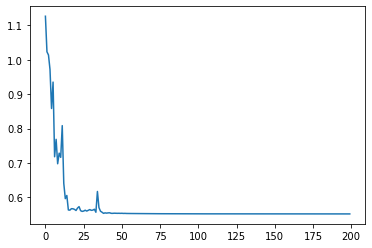

In [129]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [130]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

#gradient를 사용하지 않음
with torch.no_grad():

    model = model.to('cpu')
    X_test = torch.FloatTensor(X_test)
    y_pred = model(X_test)

    #tensor를 numpy로 바꿈
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis = 1)
    
    print(f'model의 output은 :  {y_pred[0]}' )
    print(f'argmax를 한 후의 output은 {predicted[0]}')

    #accuracy 확인
    accuracy = (accuracy_score(predicted,y_test))
    print(f'accuracy는 {accuracy}')

model의 output은 :  [1.0000000e+00 3.2914609e-12 6.4249366e-09]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815
